# Magentometer Calibration 

In [1]:
%matplotlib inline
import serial
import matplotlib
#matplotlib.use('TkAgg')  # Ou 'Qt5Agg', se preferir
import matplotlib.pyplot as plt
from collections import deque
from mpl_toolkits.mplot3d import Axes3D  # Necessário para plots 3D
import numpy as np

## Functions

Euclidean norm

In [2]:
def euclidean_distance(v1, v2):
    """
    Calcula a distância euclidiana entre dois vetores.

    Parâmetros:
        v1, v2 : array-like (listas ou arrays NumPy)

    Retorna:
        float : distância euclidiana entre v1 e v2
    """
    v1 = np.array(v1)
    v2 = np.array(v2)
    
    return np.linalg.norm(v1 - v2)

show_stream_data

Plot stream data function

In [3]:
def show_stream_data():
    """
    Lê dados do magnetômetro via serial e plota as projeções XY e ZY em tempo real.
    """
    ser = serial.Serial('/dev/ttyACM0', 115200)
    print("Reading data...")

    window_size = 100

    # Use deque with a maximum length of 100 to store the last 100 samples
    magx_data, magy_data, magz_data, magB_data = deque(maxlen=window_size), deque(maxlen=window_size), deque(maxlen=window_size), deque(maxlen=window_size)

    plt.ion()

    while True:
        line = ser.readline().decode('utf-8').strip()
        print(line)
        try:
            data = line.split(',')
            magx_data.append(float(data[0]))
            magy_data.append(float(data[1]))
            magz_data.append(float(data[2]))
            # Clear and plot the data
            plt.clf()# --- Subplot 1: projeção no plano XY ---
            ax1 = plt.subplot(1, 2, 1)
            ax1.scatter(magx_data, magy_data, c='b', s=5)
            ax1.set_title("Projeção no Plano XY")
            ax1.set_xlabel("MagX")
            ax1.set_ylabel("MagY")
            ax1.grid(True)
            ax1.axis('equal')
            # --- Subplot 2: projeção no plano ZY ---
            ax2 = plt.subplot(1, 2, 2)
            ax2.scatter(magx_data, magz_data, c='r', s=5)
            ax2.set_title("Projeção no Plano ZY")
            ax2.set_xlabel("MagX")
            ax2.set_ylabel("MagZ")
            ax2.grid(True)
            ax2.axis('equal')
            plt.tight_layout()
            plt.pause(0.01)
        except ValueError:
            print("Invalid data received, skipping...")
    ser.close()
    input("Press Enter to continue...")

Collect samples

In [4]:
# Function to collect magnetometer samples
def coleta_amostras_mag(numSamples=100):
    """
    Coleta amostras do magnetômetro via serial.

    Retorna:
        np.ndarray : matriz de amostras coletadas
    """
    ser = serial.Serial('/dev/ttyACM0', 115200)
    print("Reading data...")
    print("Moving the sensor in a figure-eight pattern...")
    cols = 3  # MagX, MagY, MagZ
    sample = np.zeros((cols,))
    matrix = np.zeros((numSamples, cols))
    count = 0
    while count < numSamples:
        line = ser.readline().decode('utf-8').strip()
        print("Amostra:", count+1, "data:", line)
        try:
            data = line.split(',')
            sample[0] = float(data[0])
            sample[1] = float(data[1])
            sample[2] = float(data[2])
            matrix[count, :] = sample
            count += 1
        except ValueError:
            print("Invalid data received, skipping...")
    ser.close()
    print("Data collection complete.")
    print(matrix)
    # salva a matriz em um arquivo .npy
    np.save('magnetometer_samples.npy', matrix)
    print("Samples saved to 'magnetometer_samples.npy'")
    return matrix

Calibration

In [5]:
# calibração do magnetômetro
def calibra_mag():
    """
    Implementa a lógica de calibração do magnetômetro.
    Parâmetros:
        matrix : np.ndarray : matriz de amostras coletadas
    """
    # Lê os dados do arquivo magnetometer_samples.npy
    data = np.load('magnetometer_samples.npy')
    print("Loaded data for calibration:")
    print("Dimensions:", data.shape)
    # Implementa a lógica de calibração aqui

    return data

In [6]:
Amostras = calibra_mag()

Loaded data for calibration:
Dimensions: (100, 3)


In [7]:
Amostras[0,0]

np.float64(5.7)

## Construção da matriz XtX

In [8]:

ri = np.zeros(10)
X = np.zeros((Amostras.shape[0],10))
for i in range (Amostras.shape[0]):
    Bpx = Amostras[i,0]
    Bpy = Amostras[i,1]
    Bpz = Amostras[i,2]
    ri[0] = Bpx**2
    ri[1] = 2*Bpx*Bpy
    ri[2] = 2*Bpx*Bpz
    ri[3] = Bpy**2
    ri[4] = 2*Bpy*Bpz
    ri[5] = Bpz**2
    ri[6] = Bpx
    ri[7] = Bpy
    ri[8] = Bpz
    ri[9] = 1
    #
    X[i,:] = ri
    
    


In [9]:
X.shape

(100, 10)

In [10]:
XtX = X.transpose()@X

In [11]:
XtX.shape

(10, 10)

In [12]:
[XtX_eigenvalues, XtX_eigenvectors] = np.linalg.eig(XtX)

In [13]:
XtX_eigenvalues

array([7.22492700e+08, 1.78917277e+08, 1.12756057e+08, 8.11403340e+06,
       4.30928059e+06, 2.32581040e+06, 2.12634094e+03, 1.22578332e-01,
       6.80775513e+02, 8.54599296e+02])

In [14]:
idx_min_eig = np.argmin(XtX_eigenvalues)

In [15]:
min_eigenvalue = XtX_eigenvalues[idx_min_eig]
min_eigenvector = XtX_eigenvectors[:,idx_min_eig]

In [16]:
min_eigenvalue

np.float64(0.12257833242952136)

In [17]:
min_eigenvector

array([ 7.70395304e-04,  2.70935004e-05, -1.37028159e-05,  8.77389491e-04,
        1.53565488e-05,  8.21566558e-04,  1.67932087e-02, -2.80839670e-03,
        6.69419856e-02,  9.97610561e-01])

In [18]:
# it should be close to zero
np.dot(XtX, min_eigenvector) -  min_eigenvalue*min_eigenvector

array([ 2.34689212e-10,  5.29502524e-11,  7.84756021e-10,  4.46684380e-11,
       -3.89824904e-11,  1.14383455e-09, -1.16967460e-12,  7.41568319e-13,
       -1.63109734e-11, -7.11514181e-14])

In [19]:
# should be 1.0
np.linalg.norm(min_eigenvector)

np.float64(1.0)

In [20]:
beta = min_eigenvector

In [21]:
A = np.matrix([ [ beta[0],beta[1],beta[2] ],\
                [ beta[1],beta[3],beta[4] ],\
                [ beta[2],beta[4],beta[5] ] ])

In [22]:
A

matrix([[ 7.70395304e-04,  2.70935004e-05, -1.37028159e-05],
        [ 2.70935004e-05,  8.77389491e-04,  1.53565488e-05],
        [-1.37028159e-05,  1.53565488e-05,  8.21566558e-04]])

In [23]:
# Wrong, it should be 1.0
np.linalg.det(A)

np.float64(5.543661214449132e-10)

In [24]:
beta68 = np.array([beta[6],beta[7],beta[8]])
V = -(1/2)*np.dot(np.linalg.inv(A),beta68)

In [25]:
V.A

array([[-11.72233664,   2.67976981, -40.98605711]])

In [26]:
[A_eigenvalues, A_eigenvectors] = np.linalg.eig(A)

In [27]:
#np.linalg.inv(A_eigenvectors)@A@A_eigenvectors - np.diag(A_eigenvalues)
A_eigenvectors.T@A@A_eigenvectors - np.diag(A_eigenvalues)

matrix([[-1.08420217e-19,  1.24670772e-19, -3.88091149e-19],
        [ 1.42643738e-19,  4.33680869e-19, -3.19703499e-19],
        [-4.67694171e-19, -3.25488648e-19,  1.08420217e-19]])

 I should calculate the non-normalize eigenvector

 \begin{align}
 [Av_1~Av_2~Av_3] &= [v_1\lambda_1~v_2\lambda_2~v_3\lambda_3] \\
 [Av_1~Av_2~Av_3]  - [v_1\lambda_1~v_2\lambda_2~v_3\lambda_3] &=0\\
A[v_1~v_2~v_3]  - diag(\lambda_1,~\lambda_2,~\lambda_3)[v_1~v_2~v_3] &=0\\
(A  - diag(\lambda_1,~\lambda_2,~\lambda_3))[v_1~v_2~v_3] &=0
 \end{align}

In [61]:
#v0 = np.linalg.solve(A-np.eye(3)*A_eigenvalues[2],np.zeros(3))
U, s, Vh = np.linalg.svd(A-np.diag(A_eigenvalues))
Vh


matrix([[-0.51398772,  0.7053655 , -0.48813536],
        [ 0.83464179,  0.54256983, -0.09482122],
        [-0.19796391,  0.45615512,  0.86760175]])

In [64]:
A@Vh[:,0] - A_eigenvalues[0]*Vh[:,0]

matrix([[1.96034130e-05],
        [8.16287552e-05],
        [7.52615195e-06]])

In [65]:
A_eigenvalues

array([0.00075926, 0.00088608, 0.00082401])

In [29]:
W_inv = A_eigenvectors@np.diag(np.sqrt(A_eigenvalues))*A_eigenvectors.T

In [30]:
W_inv

matrix([[ 0.02775088,  0.00047342, -0.00024514],
        [ 0.00047342,  0.02961579,  0.0002655 ],
        [-0.00024514,  0.0002655 ,  0.0286607 ]])

## Aplica a calibração às amostras

In [66]:
Amostras_calibradas = np.zeros(Amostras.shape)
for i in range(Amostras.shape[0]):
    Amostras_calibradas[i,:] = W_inv@(Amostras[i,:] - np.array([V[0,0],V[0,1],V[0,2]]))
    #Amostras_calibradas[i,:] = (Amostras[i,:] - np.array([V[0,0],V[0,1],V[0,2]]))
    


In [73]:
def calibrar_amostra(amostra):
    return W_inv@(amostra - V.A[0])

max_16bit_signed = (2**15) - 1
#calibrar_amostra(np.array([max_16bit_signed,0,0]))
calibrar_amostra(np.zeros(3))

matrix([[ 0.31398928, -0.06293196,  1.17110421]])

## Plots

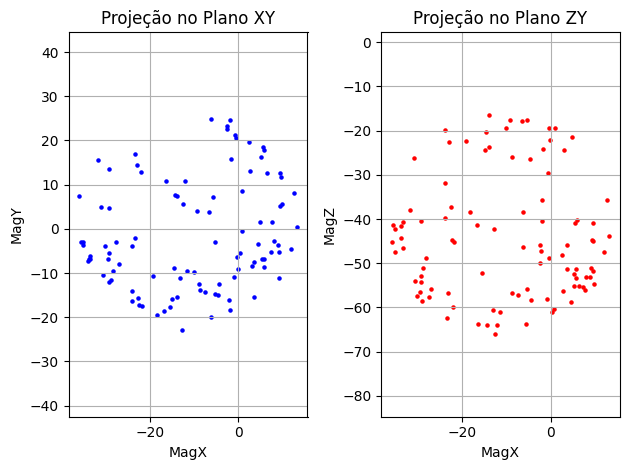

In [32]:
def plot_samples(Amostras):

    magx_data = Amostras[:,0]
    magy_data = Amostras[:,1]
    magz_data = Amostras[:,2]
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.scatter(magx_data, magy_data, c='b', s=5)
    ax1.set_title("Projeção no Plano XY")
    ax1.set_xlabel("MagX")
    ax1.set_ylabel("MagY")
    ax1.grid(True)
    ax1.axis('equal')
    # --- Subplot 2: projeção no plano ZY ---
    ax2 = plt.subplot(1, 2, 2)
    ax2.scatter(magx_data, magz_data, c='r', s=5)
    ax2.set_title("Projeção no Plano ZY")
    ax2.set_xlabel("MagX")
    ax2.set_ylabel("MagZ")
    ax2.grid(True)
    ax2.axis('equal')
    plt.tight_layout()
    plt.show()
plot_samples(Amostras)

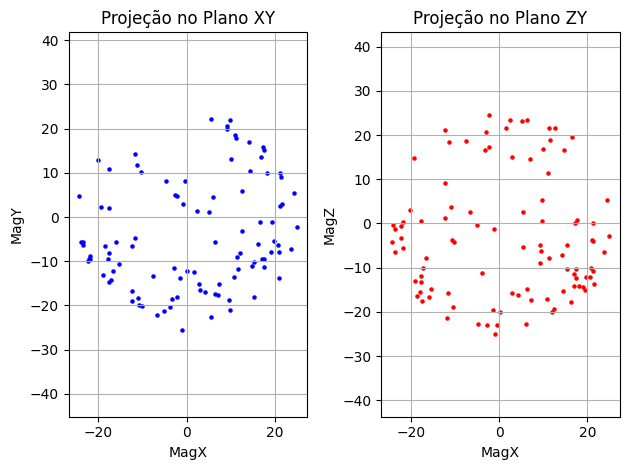

In [33]:
plot_samples(Amostras_calibradas)